In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydicom
!pip install einops
!pip install diffusers
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
import os, glob, math, functools, random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms
import math
import numpy as np
from PIL import Image
import pydicom
import importlib
from einops import rearrange, repeat
from torchvision import models
from tqdm.auto import tqdm
from diffusers import AutoencoderKL, DDPMScheduler
import lpips
from torch.utils.data import random_split

# Dataset

In [ ]:
class CTDataset(Dataset):
    """
    Custom Dataset for loading .IMA CT images from a single folder.
    """
    def __init__(self, root_dir, transform=None):
        root = Path(root_dir)

        # collect all your low/high folders however you like
        self.pairs = self.collect_pairs_by_position(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def collect_pairs_by_position(self, root: str, sort: bool = True):
        """
        Walk quarter_3mm ↔ full_3mm and quarter_1mm ↔ full_1mm in parallel,
        and pair the i-th image in each patient directory by position.
        """
        root = Path(root)
        mapping = {
            "quarter_3mm": "full_3mm",
            "quarter_1mm": "full_1mm",
        }

        pairs = []
        for small_name, full_name in mapping.items():
            small_root = root / small_name
            full_root  = root / full_name

            # each subfolder under small_root is a patient ID
            for patient_dir in sorted(small_root.iterdir()):
                if not patient_dir.is_dir():
                    continue

                # match the same patient under the full folder
                full_patient_dir = full_root / patient_dir.name
                if not full_patient_dir.exists():
                    continue

                # grab all images anywhere under that patient (rglob)
                small_imgs = list(patient_dir.rglob("*.IMA"))
                full_imgs  = list(full_patient_dir.rglob("*.IMA"))

                if sort:
                    small_imgs.sort()
                    full_imgs.sort()

                # pair by index
                for small_img, full_img in zip(small_imgs, full_imgs):
                    pairs.append((small_img, full_img))

        return pairs

    def __getitem__(self, idx):
        # Read DICOM file
        q_path, f_path = self.pairs[idx]
        ds_q = pydicom.dcmread(q_path)
        ds_f = pydicom.dcmread(f_path)
        img_q = ds_q.pixel_array.astype(np.float32)
        img_f = ds_f.pixel_array.astype(np.float32)

        # Normalize pixel values to [0, 1]
        img_q = (img_q - img_q.min()) / (img_q.max() - img_q.min() + 1e-5)
        img_f = (img_f - img_f.min()) / (img_f.max() - img_f.min() + 1e-5)

        # Convert to 8-bit and PIL Image
        img_q = (img_q * 255).astype(np.uint8)
        img_q = Image.fromarray(img_q)
        # Convert to 8-bit and PIL Image
        img_f = (img_f * 255).astype(np.uint8)
        img_f = Image.fromarray(img_f)

        # Apply transforms (e.g. ToTensor, Normalize, etc.)
        if self.transform:
            img_q = self.transform(img_q)
            img_f = self.transform(img_f)

        # Return image and dummy label
        return img_q, img_f


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ensure it's single‑channel
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])           # mean/std for one channel
])

# AutoEncoder

# Difusion

## Model

### Building blocks

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [ ]:
class ResnetBlockTime(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, groups=32):
        super().__init__()
        self.norm1 = nn.GroupNorm(groups, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Sequential(Swish(), nn.Linear(time_emb_dim, out_ch * 2))
        self.norm2 = nn.GroupNorm(groups, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.norm1(x); h = Swish()(h); h = self.conv1(h)
        scale, shift = self.time_mlp(t_emb).chunk(2, dim=1)
        h = h * (scale[:, :, None, None] + 1) + shift[:, :, None, None]
        h = self.norm2(h); h = Swish()(h); h = self.conv2(h)
        return h + self.res_conv(x)

In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, groups=32):
        super().__init__()
        self.norm1 = nn.GroupNorm(groups, in_ch)
        self.act1  = Swish()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)

        self.norm2 = nn.GroupNorm(groups, out_ch)
        self.act2  = Swish()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

        if in_ch != out_ch:
            self.res_conv = nn.Conv2d(in_ch, out_ch, 1)
        else:
            self.res_conv = nn.Identity()

    def forward(self, x):
        h = self.conv1(self.act1(self.norm1(x)))
        h = self.conv2(self.act2(self.norm2(h)))
        return h + self.res_conv(x)

In [ ]:
class Downsample(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.op = nn.Conv2d(ch, ch, 4, stride=2, padding=1)
    def forward(self, x): return self.op(x)

In [ ]:
class Upsample(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.op = nn.ConvTranspose2d(ch, ch, 4, stride=2, padding=1)
    def forward(self, x): return self.op(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(
        self,
        in_channels: int = 1,
        hidden_dims: list[int] = [64, 128, 256],
        latent_dim: int = 16,
        attn_resolutions: list[int] = [16],      # apply attention when H=W equals these
        diffusion_embed_dim: int = 512
    ):
        super().__init__()
        self.latent_dim = latent_dim

        # input convolution
        self.conv_in = nn.Conv2d(in_channels, hidden_dims[0], 3, padding=1)

        # build down‑stack
        self.down_blocks = nn.ModuleList()
        ch = hidden_dims[0]
        for h in hidden_dims:
            block = nn.ModuleList([ ResnetBlock(ch, h) ])
            if h in attn_resolutions:
                block.append(AttentionBlock(h))
            block.append(Downsample(h))
            self.down_blocks.append(block)
            ch = h

        # final ResNet (no downsample)
        self.mid_block = nn.ModuleList([
            ResnetBlock(ch, ch),
            AttentionBlock(ch),
            ResnetBlock(ch, ch),
        ])

        # produce μ & log var: double‑z
        self.conv_mu_logvar = nn.Conv2d(ch, 2*latent_dim, 3, padding=1)

        # quantization bridges
        self.quant_conv     = nn.Conv2d(latent_dim, diffusion_embed_dim, 1)
        self.post_quant_conv= nn.Conv2d(diffusion_embed_dim, latent_dim, 1)

    def forward(self, x):
        h = self.conv_in(x)
        for block in self.down_blocks:
            for layer in block:
                h = layer(h)

        for layer in self.mid_block:
            h = layer(h)

        # double‑z
        stats = self.conv_mu_logvar(h)
        mu, logvar = torch.chunk(stats, 2, dim=1)

        # quant bridges (optional, e.g. for your diffusion embedding)
        quant  = self.quant_conv(mu)           # maps μ→embed_dim
        post_q = self.post_quant_conv(quant)   # back to latent_dim

        return mu, logvar, post_q

In [ ]:
class Decoder(nn.Module):
    def __init__(
        self,
        out_channels: int = 1,
        hidden_dims: list[int] = [256, 128, 64],
        latent_dim: int = 16,
        attn_resolutions: list[int] = [16], **kwargs
    ):
        super().__init__()

        # initial expand
        self.initial = nn.Conv2d(latent_dim, hidden_dims[0], 3, padding=1)

        # build up‑stack
        self.up_blocks = nn.ModuleList()
        ch = hidden_dims[0]
        for h in hidden_dims[1:]:
            block = nn.ModuleList([ ResnetBlock(ch, h) ])
            if h in attn_resolutions:
                block.append(AttentionBlock(h))
            block.append(Upsample(h))
            self.up_blocks.append(block)
            ch = h

        # final conv to image
        self.conv_out = nn.Sequential(
            ResnetBlock(ch, ch),
            nn.GroupNorm(32, ch),
            Swish(),
            Upsample(ch),
            nn.Conv2d(ch, out_channels, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        h = self.initial(z)
        for block in self.up_blocks:
            for layer in block:
                h = layer(h)
        return self.conv_out(h)


In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, ch, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        head_dim = ch // num_heads
        assert head_dim * num_heads == ch, "ch must be divisible by num_heads"

        self.to_q = nn.Conv2d(ch, ch, 1)
        self.to_k = nn.Conv2d(ch, ch, 1)
        self.to_v = nn.Conv2d(ch, ch, 1)
        self.proj = nn.Conv2d(ch, ch, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        N = H * W
        h = self.num_heads
        d = C // h

        # project
        q = self.to_q(x).view(B, h, d, N)
        k = self.to_k(x).view(B, h, d, N)
        v = self.to_v(x).view(B, h, d, N)

        # scaled dot-product: (B, h, N, N)
        attn = torch.einsum('b h d n, b h d m -> b h n m', q, k)
        attn = attn * (d ** -0.5)
        attn = torch.softmax(attn, dim=-1)

        # attend to v → (B, h, d, N)
        out = torch.einsum('b h n m, b h d m -> b h d n', attn, v)
        out = out.contiguous().view(B, C, H, W)

        return self.proj(out)

In [ ]:
class CrossAttentionBlock(nn.Module):
    def __init__(self, ch, cond_ch, num_heads=4):
        super().__init__()
        self.norm      = nn.GroupNorm(32, ch)
        self.num_heads = num_heads
        head_dim       = ch // num_heads
        assert head_dim * num_heads == ch, "ch must divide evenly"
        self.to_q = nn.Conv2d(ch, ch, 1)
        self.to_k = nn.Conv2d(cond_ch, ch, 1)
        self.to_v = nn.Conv2d(cond_ch, ch, 1)
        self.proj = nn.Conv2d(ch, ch, 1)

    def forward(self, x, cond):
        B, C, H, W = x.shape
        h = self.num_heads; d = C // h
        x_norm = self.norm(x)
        # match spatial size
        if cond.shape[-2:] != (H, W):
            cond = F.interpolate(cond, size=(H, W), mode='bilinear', align_corners=False)

        q = self.to_q(x_norm).view(B, h, d, H*W).transpose(-1,-2)  # [B,h,N,d]
        k = self.to_k(cond)   .view(B, h, d, H*W).transpose(-1,-2)
        v = self.to_v(cond)   .view(B, h, d, H*W).transpose(-1,-2)

        attn = (q @ k.transpose(-1,-2)) * (d**-0.5)
        attn = attn.softmax(dim=-1)
        out  = (attn @ v).transpose(-1,-2).contiguous().view(B, C, H, W)
        return x + self.proj(out)


In [ ]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half = self.dim // 2
        freq = torch.exp(
            torch.arange(half, device=t.device) * -(math.log(10000) / (half - 1))
        )
        args = t[:, None] * freq[None]
        return torch.cat([args.sin(), args.cos()], dim=-1)

In [ ]:
class ResnetBlockTime(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, groups=32):
        super().__init__()
        self.norm1 = nn.GroupNorm(groups, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Sequential(Swish(), nn.Linear(time_emb_dim, out_ch * 2))
        self.norm2 = nn.GroupNorm(groups, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.norm1(x); h = Swish()(h); h = self.conv1(h)
        scale, shift = self.time_mlp(t_emb).chunk(2, dim=1)
        h = h * (scale[:, :, None, None] + 1) + shift[:, :, None, None]
        h = self.norm2(h); h = Swish()(h); h = self.conv2(h)
        return h + self.res_conv(x)

### UNET

In [ ]:
class LatentDiffusionUNetConditional(nn.Module):
    def __init__(
        self,
        in_ch: int = 16,
        cond_ch: int = 16,
        base_ch: int = 128,
        ch_mults: tuple[int,...] = (1,2,4,8),
        time_dim: int = 512,
        attn_res: tuple[int,...] = (8,16)
    ):
        super().__init__()
        self.cond_ch = cond_ch
        # time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_dim),
            nn.Linear(time_dim, time_dim*4), Swish(),
            nn.Linear(time_dim*4, time_dim)
        )
        # initial conv: noisy + cond
        self.init_conv = nn.Conv2d(in_ch+cond_ch, base_ch, 3, padding=1)
        # channel sizes
        chs = [base_ch*m for m in ch_mults]

        # Down path
        self.downs = nn.ModuleList()
        prev_ch   = base_ch
        for i, out_ch in enumerate(chs):
            layers = []
            layers.append(ResnetBlockTime(prev_ch, out_ch, time_dim))
            if 2**i in attn_res: layers.append(AttentionBlock(out_ch))
            layers.append(CrossAttentionBlock(out_ch, cond_ch))
            if i < len(chs)-1: layers.append(Downsample(out_ch))
            self.downs.append(nn.ModuleList(layers))
            prev_ch = out_ch

        # Middle
        mid_ch = chs[-1]
        self.mid = nn.ModuleList([
            ResnetBlockTime(mid_ch, mid_ch, time_dim),
            AttentionBlock(mid_ch),
            CrossAttentionBlock(mid_ch, cond_ch),
            ResnetBlockTime(mid_ch, mid_ch, time_dim),
        ])

        # Up path
        self.ups = nn.ModuleList()
        for i in range(len(chs)-1):
            in_ch_up = chs[-1-i]
            skip_ch  = chs[-2-i]
            out_ch   = skip_ch
            layers = nn.ModuleDict({
                'upsample': Upsample(in_ch_up),
                'resnet':   ResnetBlockTime(in_ch_up + skip_ch, out_ch, time_dim),
                'cross':    CrossAttentionBlock(out_ch, cond_ch)
            })
            if 2**(len(chs)-2-i) in attn_res:
                layers['attn'] = AttentionBlock(out_ch)
            self.ups.append(layers)

        # Final output
        self.final = nn.Sequential(
            nn.GroupNorm(32, chs[0]),
            Swish(),
            nn.Conv2d(chs[0], in_ch, 3, padding=1)
        )

    def forward(self, x, t, cond):
        # x: noisy target latent [B,in_ch,H,W]
        # cond: low-dose latent [B,cond_ch,H,W]
        t_emb = self.time_mlp(t)
        h     = self.init_conv(torch.cat([x, cond], dim=1))
        skips = []

        # Down
        for block in self.downs:
            for layer in block:
                if isinstance(layer, Downsample):
                    skips.append(h)
                    h = layer(h)
                elif isinstance(layer, CrossAttentionBlock):
                    h = layer(h, cond)
                else:
                    h = layer(h, t_emb) if isinstance(layer, ResnetBlockTime) else layer(h)

        # Middle
        for layer in self.mid:
            if isinstance(layer, CrossAttentionBlock):
                h = layer(h, cond)
            else:
                h = layer(h, t_emb) if isinstance(layer, ResnetBlockTime) else layer(h)

        # Up
        for up in self.ups:
            h = up['upsample'](h)             # 1) upsample
            skip = skips.pop()
            h = torch.cat([h, skip], dim=1)  # 2) concat
            h = up['resnet'](h, t_emb)       # 3a) resnet
            if 'attn' in up: h = up['attn'](h)       # 3b) optional self-attn
            h = up['cross'](h, cond)                # 3c) cross-attn

        return self.final(h)

## Train

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")

old_out = vae.decoder.conv_out
w2 = old_out.weight.data                             # [3, C, k, k]
w2_gray = w2.mean(dim=0, keepdim=True)                # [1, C, k, k]

new_out = nn.Conv2d(
    in_channels=old_out.in_channels,
    out_channels=1,
    kernel_size=old_out.kernel_size,
    stride=old_out.stride,
    padding=old_out.padding,
    bias=(old_out.bias is not None)
)
new_out.weight.data.copy_(w2_gray)
if old_out.bias is not None:
    new_out.bias.data.fill_(old_out.bias.data.mean())

vae.decoder.conv_out = new_out

# freeze everything
for p in vae.parameters():
    p.requires_grad = False

vae.to(device).eval()

In [ ]:
ckpt_path = "/content/drive/MyDrive/CT Models/VAE/pt_vae_2_epoch_100.pth"
state_dict = torch.load(ckpt_path, map_location=device)
vae.load_state_dict(state_dict)
vae.to(device).eval()

In [ ]:
guidance_scale = 5.0

@torch.no_grad()
def sample_ddim_guided(z_cond, scheduler, diffusion):
    B = z_cond.size(0)
    # start from pure noise
    z = torch.randn_like(z_cond)

    for t in scheduler.timesteps:
        t_int   = int(t.item() if isinstance(t, torch.Tensor) else t)
        t_batch = torch.full((B,), t_int, device=device, dtype=torch.long)

        # 1) unconditional prediction (cond dropped → zeros)
        eps_uncond = diffusion(z, t_batch, cond=torch.zeros_like(z_cond))
        # 2) conditional prediction
        eps_cond   = diffusion(z, t_batch, cond=z_cond)
        # 3) blend for classifier-free guidance
        eps = eps_uncond + guidance_scale * (eps_cond - eps_uncond)

        # 4) take a DDIM step
        out = scheduler.step(eps, t_int, z, return_dict=True)
        z   = out.prev_sample

    return z

def load_and_preprocess(path):
    ds  = pydicom.dcmread(path)
    arr = ds.pixel_array.astype(float)
    arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-5)
    pil = Image.fromarray((arr * 255).astype("uint8"))
    return transform(pil).unsqueeze(0)

def plot_epoch(vae, diffusion, scheduler):
  import matplotlib.pyplot as plt
  transform = transforms.Compose([
      transforms.Grayscale(1),
      transforms.Resize(256),
      transforms.CenterCrop(256),
      transforms.ToTensor(),
      transforms.Normalize([0.5], [0.5]),
  ])

  low_path  = "/content/drive/MyDrive/CT/full_3mm/L067/full_3mm/L067_FD_3_1.CT.0002.0001.2015.12.22.18.12.07.5968.358090401.IMA"
  high_path = "/content/drive/MyDrive/CT/quarter_3mm/L067/quarter_3mm/L067_QD_3_1.CT.0004.0001.2015.12.22.18.12.56.428910.358293547.IMA"

  low_img_t  = load_and_preprocess(low_path).to(device)   # [1,1,H,W]
  high_img_t = load_and_preprocess(high_path).to(device)  # optional

  with torch.no_grad():
      low_rgb = low_img_t.repeat(1,3,1,1)
      enc     = vae.encode(low_rgb)
      z_cond  = enc.latent_dist.sample() * vae.config.scaling_factor

  with torch.no_grad():
      low_rgb = low_img_t.repeat(1,3,1,1)
      enc     = vae.encode(low_rgb)
      z_pred = sample_ddim_guided(z_cond, scheduler, diffusion) * vae.config.scaling_factor

  with torch.no_grad():
      dec     = vae.decode(z_pred / vae.config.scaling_factor).sample
      pred    = (dec / 2 + 0.5).clamp(0,1)[0,0]  # [H,W] float in [0,1]

  print(low_img_t.shape)
  fig, axes = plt.subplots(1,3,figsize=(12,4))
  for ax, img, title in zip(
      axes,
      [low_img_t[0,0].cpu(), pred.cpu(), high_img_t[0,0].cpu()],
      ["Low-Dose Input", "Predicted High-Dose", "Ground-Truth High-Dose"]
  ):
      ax.imshow(img, cmap="gray")
      ax.set_title(title)
      ax.axis("off")

  plt.tight_layout()
  plt.show()

In [ ]:
def train_conditional_diffusion(
    diffusion_model: nn.Module,
    autoencoder: AutoencoderKL,
    train_loader: DataLoader,
    val_loader:   DataLoader,
    epochs: int = 100,
    lr: float = 1e-4,
    device: torch.device = device,
    T: int = 1000,
    save_dir: str = "./checkpoints",
    start_epoch: int = 1,
    drop_prob: float = 0.1,
):
    os.makedirs(save_dir, exist_ok=True)
    diffusion_model.train()

    # ────────────────────────────
    # use a cosine schedule instead of squaredcos_cap_v2
    # ────────────────────────────
    scheduler = DDPMScheduler(
        beta_start=1e-4,
        beta_end=0.02,
        beta_schedule="squaredcos_cap_v2"
    )
    scheduler.set_timesteps(T, device=device)
    alphas          = 1.0 - scheduler.betas
    alphas_cumprod  = torch.cumprod(alphas, dim=0)
    alphas = alphas.to(device)
    alphas_cumprod = alphas_cumprod.to(device)

    optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=lr)
    perc_net  = lpips.LPIPS(net='vgg').to(device)

    for epoch in range(start_epoch, start_epoch + epochs):
        pbar       = tqdm(train_loader, desc=f"Epoch {epoch}")
        train_loss = 0.0

        # ────────────────────────────
        # training loop adds LPIPS + image‐space loss
        # ────────────────────────────
        for low_img, high_img in pbar:
            low_img, high_img = low_img.to(device), high_img.to(device)
            with torch.no_grad():
                enc_low  = autoencoder.encode(low_img.repeat(1,3,1,1))
                z_low    = enc_low.latent_dist.sample() * autoencoder.config.scaling_factor
                enc_high = autoencoder.encode(high_img.repeat(1,3,1,1))
                z_high   = enc_high.latent_dist.sample() * autoencoder.config.scaling_factor

            B = z_high.size(0)
            t = torch.randint(0, T, (B,), device=device)

            a_t     = alphas_cumprod[t].view(B,1,1,1)
            sigma_t = torch.sqrt(1 - a_t)
            noise   = torch.randn_like(z_high)
            z_t     = torch.sqrt(a_t) * z_high + sigma_t * noise

            mask       = (torch.rand(B, device=device) < drop_prob).view(B,1,1,1)
            cond_input = torch.where(mask, torch.zeros_like(z_low), z_low)

            pred_noise = diffusion_model(z_t, t, cond=cond_input)
            l_mse      = F.mse_loss(pred_noise, noise)

            # decode for image–space supervision
            with torch.no_grad():
                z_uncond = sample_ddim_guided(z_low, scheduler, diffusion_model)
            dec        = autoencoder.decode(z_uncond / autoencoder.config.scaling_factor).sample
            img_pred   = (dec / 2 + 0.5).clamp(0,1)
            img_tgt    = high_img.repeat(1,3,1,1)

            l_lpips = perc_net(img_pred, img_tgt).mean()
            l_img   = F.l1_loss(img_pred, img_tgt)

            loss = l_mse + λ_lpips * l_lpips + λ_img * l_img

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix(train_loss=train_loss / (pbar.n+1))


        print(f"Epoch {epoch}  train_loss={train_loss/len(train_loader):.4f}  ")

        # ────────────────────────────
        # checkpoint + back to train mode
        # ────────────────────────────
        torch.save(diffusion_model.state_dict(), f"{save_dir}/pt-diffusion_3_epoch_{epoch}.pth")
        plot_epoch(vae=vae, diffusion=diffusion_model, scheduler=scheduler)
        diffusion_model.train()

In [ ]:
device = torch.device("cuda")
λ_lpips = 0.1
λ_img   = 0.5
epochs = 500
batch_size = 16
lr = 1e-4
latent_channels = 16
save_dir = "/content/drive/MyDrive/CT Models/Diffusion"

In [ ]:
# ds = CTDataset("/content/drive/MyDrive/CT", transform)
ds = CTDataset("/content/drive/MyDrive/CT/", transform=transform)
n_val   = int(len(ds) * 0.1)
n_train = len(ds) - n_val

train_ds, vaal_ds = random_split(ds, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
# val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
latent_ch = vae.config.latent_channels
diffusion_model = LatentDiffusionUNetConditional(
    in_ch   = latent_ch,
    cond_ch = latent_ch,
    base_ch = 128,
    ch_mults= (1,2,4,8),
    time_dim= 512,
    attn_res= (8,16)
).to(device)
ckpt = torch.load("/content/drive/MyDrive/CT Models/Diffusion/pt-diffusion_3_epoch_10.pth", map_location=device)
diffusion_model.load_state_dict(ckpt)
diffusion_model.eval()

In [ ]:
train_conditional_diffusion(
    diffusion_model=diffusion_model,
    autoencoder=vae,
    train_loader=train_loader,
    val_loader=None,
    epochs=100,
    lr=1e-4,
    device=device,
    T=1000,
    save_dir=save_dir,
    start_epoch=10,
    drop_prob=0.1
)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 232MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


Epoch 10:   0%|          | 0/468 [00:00<?, ?it/s]

<ipython-input-26-a4789c73eab3>:71: UserWarning: Using a target size (torch.Size([16, 3, 256, 256])) that is different to the input size (torch.Size([16, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  l_img   = F.l1_loss(img_pred, img_tgt)


KeyboardInterrupt: 

# Test

## ROI

In [ ]:
def pred_image(low_img_t, diffusion, vae):
  transform = transforms.Compose([
      transforms.Grayscale(1),
      transforms.Resize(256),
      transforms.CenterCrop(256),
      transforms.ToTensor(),
      transforms.Normalize([0.5], [0.5]),
  ])

  with torch.no_grad():
      low_rgb = low_img_t.repeat(1,3,1,1)
      enc     = vae.encode(low_rgb)
      z_cond  = enc.latent_dist.sample() * vae.config.scaling_factor

  with torch.no_grad():
      low_rgb = low_img_t.repeat(1,3,1,1)
      enc     = vae.encode(low_rgb)
      z_pred = sample_ddim_guided(z_cond, scheduler, diffusion) * vae.config.scaling_factor

  with torch.no_grad():
      dec     = vae.decode(z_pred / vae.config.scaling_factor).sample
      pred    = (dec / 2 + 0.5).clamp(0,1)[0,0]  # [H,W] float in [0,1]
  return pred

In [ ]:
def compute_cnr(img_tensor, roi_coords, bg_coords, window_low, window_high):
    # bring [-1,1] → [0,1]
    hu = (img_tensor.cpu().numpy() * 0.5 + 0.5) \
         * (window_high - window_low) + window_low

    y1, y2, x1, x2 = roi_coords
    bg1, bg2, bg3, bg4 = bg_coords

    roi_patch = hu[y1:y2, x1:x2]
    bg_patch  = hu[bg1:bg2, bg3:bg4]

    if roi_patch.size == 0 or bg_patch.size == 0:
        raise ValueError(f"Empty ROI or BG slice: roi={roi_coords}, bg={bg_coords}")

    mu_roi   = roi_patch.mean()
    mu_bg    = bg_patch.mean()
    sigma_bg = bg_patch.std()

    return abs(mu_roi - mu_bg) / sigma_bg


In [ ]:
def predict(vae, diffusion, scheduler, low_path, roi_coords, bg_coord):

    low_img_t  = load_and_preprocess(low_path).to(device)   # [1,1,H,W]


    low = low_img_t[0,0]
    pred = pred_image(low_img_t, diffusion, vae)
    result = {"image":low_path}
    for name, img in [
        ('low-dose',    low),
        ('predicted',   pred),
    ]:
        cnr = compute_cnr(
            img,
            roi_coords,
            bg_coords,
            window_low=-600,
            window_high=900
        )
        if name == 'low-dose':
            result['low-dose'] = cnr
        else:
            result['predicted'] = cnr
    return result

In [ ]:
scheduler = DDPMScheduler(
        beta_start=1e-4,
        beta_end=0.02,
        beta_schedule="squaredcos_cap_v2"
    )
scheduler.set_timesteps(1000, device=device)

In [ ]:
import pandas as pd
from datetime import date, datetime

def normalize_interval(x):
    # x pode vir como Timestamp, datetime.date, str, float (NaN), ...
    if pd.isna(x):
        return pd.NA
    if isinstance(x, (pd.Timestamp, datetime, date)):
        return f"{x.day}-{x.month}"
    return str(x)

In [ ]:
new_rois_dict = []
for sheet in ["1 mm", "3 mm"]:
  df = pd.read_excel("/content/drive/MyDrive/BRACIS ROIs.xlsx", engine="openpyxl", header=1, sheet_name=sheet, converters={"Intervalo de Cortes": normalize_interval})

  rois_dict = df.to_dict(orient="records")

  for roi_dict in rois_dict:
    if not pd.isna(roi_dict["Imagem"]):
      new_roi_dict = {}
      new_roi_dict["x_min_1"] = int(int(str(roi_dict["IE (x,y)"]).split(".")[0])/2)
      new_roi_dict["x_max_1"] = new_roi_dict["x_min_1"] + 10
      new_roi_dict["y_max_1"] = int(int(str(roi_dict["IE (x,y)"]).split(".")[1])/2)
      new_roi_dict["y_min_1"] = new_roi_dict["y_max_1"] - 10
      roi_dict["Caminho"] = roi_dict["Caminho"].replace("\\", "/")
      new_roi_dict["Caminho"] = f'/content/drive/MyDrive/CT/{roi_dict["Caminho"]}'
      new_roi_dict["first_image_index"] = int(str(roi_dict['Intervalo de Cortes']).split("-")[0]) - 1
      if int(str(roi_dict['Intervalo de Cortes']).split("-")[0]) - 1 != 0:
        print(roi_dict['Caminho'])
        print(roi_dict['Intervalo de Cortes'])
      new_roi_dict["final_image_index"] = int(str(roi_dict['Intervalo de Cortes']).split("-")[1]) - 1
      new_rois_dict.append(new_roi_dict)
    else:
      new_rois_dict[-1]["x_min_2"] = int(int(str(roi_dict["IE (x,y)"]).split(".")[0])/2)
      new_rois_dict[-1]["x_max_2"] = int(int(str(roi_dict["IE (x,y)"]).split(".")[0])/2) + 10
      new_rois_dict[-1]["y_max_2"] = int(int(str(roi_dict["IE (x,y)"]).split(".")[1])/2)
      new_rois_dict[-1]["y_min_2"] = int(int(str(roi_dict["IE (x,y)"]).split(".")[1])/2) - 10



In [ ]:
results = []
for i, rois in enumerate(new_rois_dict[:10]):
  folder = Path(rois["Caminho"])
  imgs = list(folder.iterdir())
  imgs = imgs[rois["first_image_index"]:rois["final_image_index"]]
  for low_path in imgs:
    roi_coords = (rois["y_min_1"], rois["y_max_1"], rois["x_min_1"], rois["x_max_1"])
    bg_coords = (rois["y_min_2"], rois["y_max_2"], rois["x_min_2"], rois["x_max_2"])
    result = predict(vae, diffusion_model, scheduler, low_path, roi_coords=roi_coords, bg_coord=bg_coords)
    result["roi"] = rois["y_min_1"], rois["y_max_1"], rois["x_min_1"], rois["x_max_1"]
    result["bg"] = rois["y_min_2"], rois["y_max_2"], rois["x_min_2"], rois["x_max_2"]
    results.append(result)
  print(i/len(new_rois_dict))
print(results)
results_df = pd.DataFrame(results).to_csv("/content/drive/MyDrive/results_0_10.csv")

In [ ]:
results_df = pd.DataFrame(results).to_csv("/content/drive/MyDrive/results_2.csv")

In [ ]:
results_df = pd.read_csv("/content/drive/MyDrive/results_2.csv", index_col=0)

In [ ]:
results_df["diff"] =  results_df["predicted"] - results_df["low-dose"]

In [ ]:
results_df.describe()

In [ ]:
pd.DataFrame(new_rois_dict)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_epoch(vae, diffusion, scheduler, roi_coords=(150, 250, 80, 180),
                low_path  = "/content/drive/MyDrive/CT/full_3mm/L067/full_3mm/L067_FD_3_1.CT.0002.0001.2015.12.22.18.12.07.5968.358090401.IMA", high_path=None
                # high_path = "/content/drive/MyDrive/CT/quarter_3mm/L067/quarter_3mm/L067_QD_3_1.CT.0004.0001.2015.12.22.18.12.56.428910.358293547.IMA"
                ):
    """
    vae:         your fine‐tuned AutoencoderKL
    diffusion:  your diffusion model
    scheduler:  your DDPMScheduler
    roi_coords: (y1, y2, x1, x2) in pixel coordinates
    """
    # preprocessing transform (if needed)
    transform = transforms.Compose([
        transforms.Grayscale(1),
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

    # load your low/high paths and preprocess to [1,1,H,W]

    low_img_t  = load_and_preprocess(low_path).to(device)   # [1,1,256,256]

    # encode + sample conditioning latent
    with torch.no_grad():
        low_rgb = low_img_t.repeat(1,3,1,1)
        enc     = vae.encode(low_rgb)
        z_cond  = enc.latent_dist.sample() * vae.config.scaling_factor

    # diffusion sampling
    with torch.no_grad():
        z_pred = sample_ddim_guided(z_cond, scheduler, diffusion) * vae.config.scaling_factor

    # decode to image
    with torch.no_grad():
        dec  = vae.decode(z_pred / vae.config.scaling_factor).sample
        pred = (dec / 2 + 0.5).clamp(0,1)[0,0]  # [256,256]


    panels = [
        pred.cpu(),
        low_img_t[0,0].cpu(),
    ]
    titles = ["Predicted High-Dose", "Low-Dose Input"]
    if high_path:
      high_img_t = load_and_preprocess(high_path).to(device)  # [1,1,256,256]
      panels.append(high_img_t[0,0].cpu())
      titles.append("Ground-Truth High-Dose")

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    y1, y2, x1, x2 = roi_coords
    for ax, img, title in zip(axes, panels, titles):
        ax.imshow(img, cmap="gray", vmin=0, vmax=1)
        # Draw the ROI rectangle
        print(f"x1 {x1}")
        print(f"y1 {y1}")
        print(f"x2 {x2}")
        print(f"y2 {y2}")
        print(f"Width {x2 - x1}")
        print(f"Height {y2 - y1}")
        rect = patches.Rectangle(
            (x1, y1),            # (xmin, ymin)
            x2 - x1,             # width
            y2 - y1,             # height
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.imshow(img, cmap="gray", vmin=img.min(), vmax=img.max())
        ax.add_patch(rect)
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

x1 80
y1 150
x2 180
y2 250
Width 100
Height 100
x1 80
y1 150
x2 180
y2 250
Width 100
Height 100


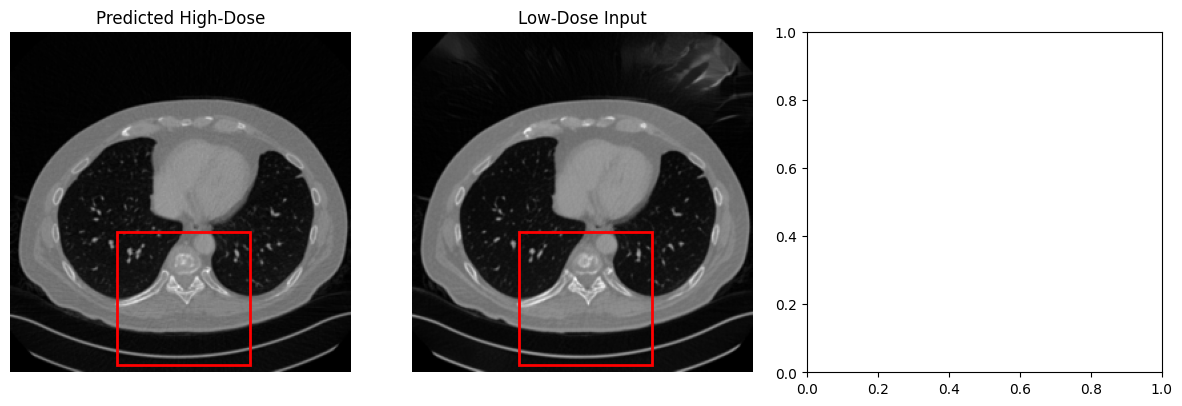

In [ ]:
a = results_df[results_df['diff'] == results_df['diff'].max()]
plot_epoch(vae, diffusion_model, scheduler, roi_coords=(150, 250, 80, 180), low_path=a.image.values[0])

x1 80
y1 150
x2 180
y2 250
Width 100
Height 100
x1 80
y1 150
x2 180
y2 250
Width 100
Height 100


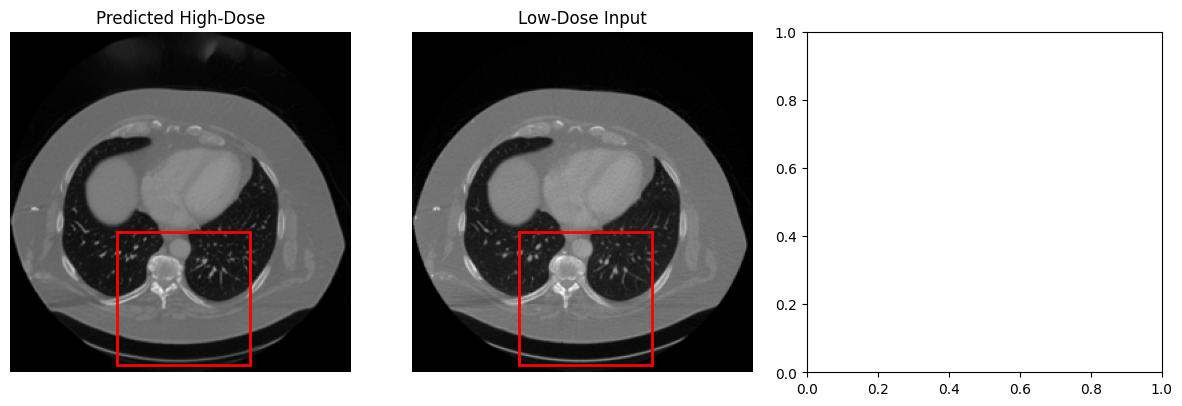

In [ ]:
a = results_df[results_df['diff'] == results_df['diff'].min()]
plot_epoch(vae, diffusion_model, scheduler, roi_coords=(150, 250, 80, 180), low_path=a.image.values[0])

x1 59.0
y1 161.0
x2 69.0
y2 151.0
Width 10.0
Height -10.0
x1 59.0
y1 161.0
x2 69.0
y2 151.0
Width 10.0
Height -10.0
x1 59.0
y1 161.0
x2 69.0
y2 151.0
Width 10.0
Height -10.0


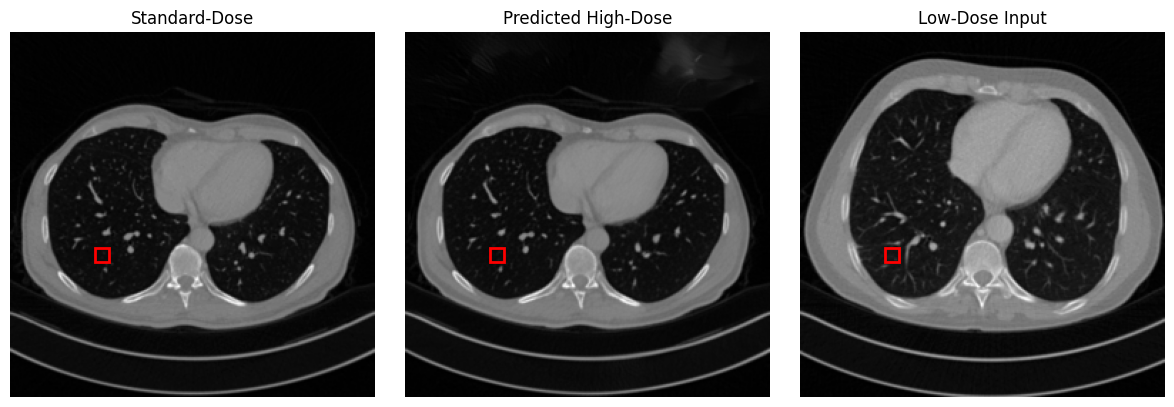

In [ ]:
plot_epoch(vae, diffusion_model, scheduler, roi_coords=(322/2, 302/2, 118/2, 138/2), low_path="/content/drive/MyDrive/CT/QD_1mm/L008/quarter_1mm/L008_QD_1_1.CT.0009.0001.2016.01.21.14.08.17.919778.138833523.IMA")
#y1, y2, x1, x2

x1 210
y1 98
x2 220
y2 58
Width 10
Height -40
x1 210
y1 98
x2 220
y2 58
Width 10
Height -40
x1 210
y1 98
x2 220
y2 58
Width 10
Height -40


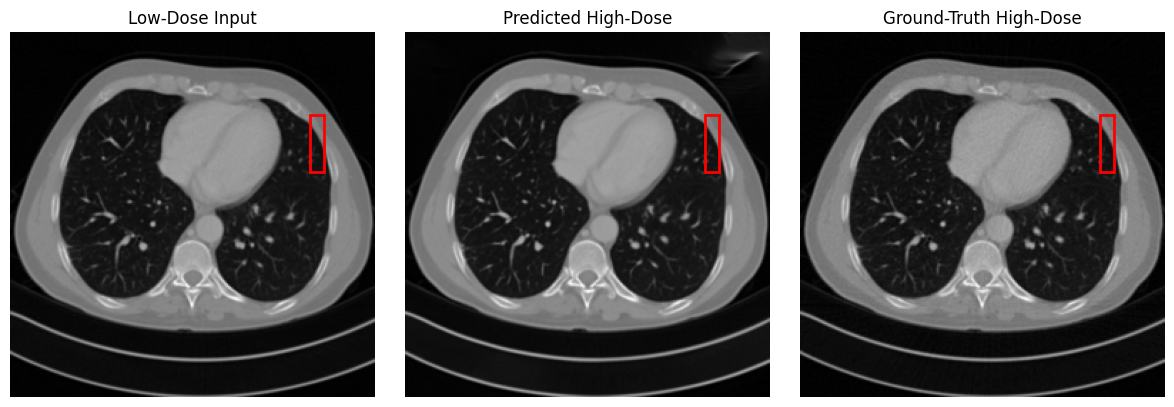

In [ ]:
plot_epoch(vae, diffusion_model, scheduler, roi_coords=(98, 58, 210, 220))
#y1, y2, x1, x2

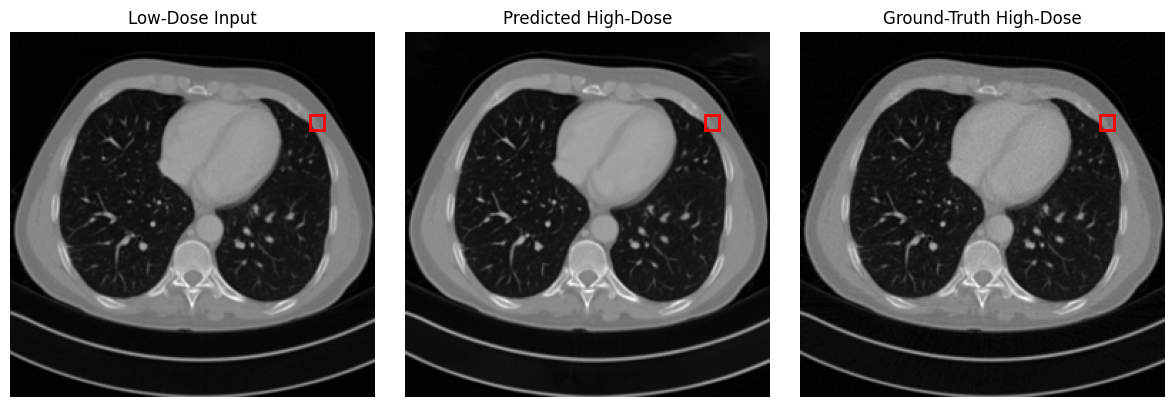

In [ ]:
plot_epoch(vae, diffusion_model, scheduler, roi_coords=(68, 58, 210, 220))
#y1, y2, x1, x2